In [1]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
from functools import partial
import optax
from tqdm import trange

from models.diffusion import VariationalDiffusionModel
from models.transformer import Transformer

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

%load_ext autoreload
%autoreload 2

2024-03-11 15:23:03.240640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 15:23:03.250116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 15:23:06.477976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


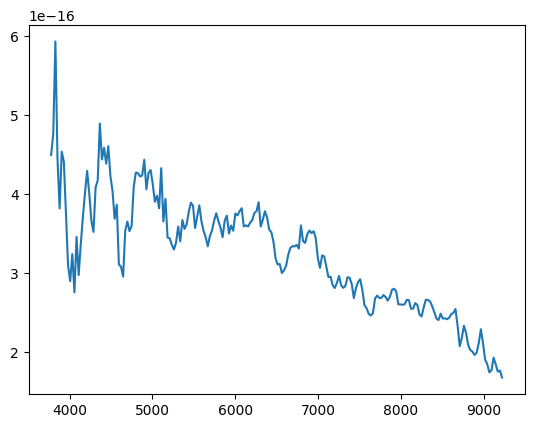

In [3]:
import pandas as pd

spectra = pd.read_csv("../data/ZTFBTS_spectra/ZTF18aaqpeoq.csv", header=None)

# Get first and second columns
wavelength = spectra[0]
flux = spectra[1]

# Plot
import matplotlib.pyplot as plt
plt.plot(wavelength, flux)

In [80]:
# Get all the CSV files in the directory
import os
import glob
from tqdm import tqdm

files = glob.glob("../data/ZTFBTS_spectra/*.csv")  # [:4000]

# Loop over spectra, pad to max length, and add to training
max_length = 1000
wavelengths = []
fluxes = []
masks = []

len_list = []

for file in tqdm(files):
    # Read in the CSV
    spectra_pd = pd.read_csv(file, header=None)

    len_list.append(len(spectra_pd))
    
    if len(spectra_pd) > max_length:
        print(f"Skipping {file} because it's too long with length {len(spectra_pd)}")
        continue

    wavelength = spectra_pd[0].values
    flux = spectra_pd[1].values
    
    # Pad the flux, wavelength, and mask
    flux = np.pad(flux, (0, max_length - len(flux)))
    wavelength = np.pad(wavelength, (0, max_length - len(wavelength)))
    
    # Mask should be zero where the padding is
    mask = np.ones(max_length)
    mask = mask.at[len(spectra_pd):].set(0)

    # Append to the list
    fluxes.append(flux)
    wavelengths.append(wavelength)
    masks.append(mask)

# Stack the fluxes, spectra, and masks  
fluxes = np.stack(fluxes)
wavelengths = np.stack(wavelengths)
masks = np.stack(masks)
    
# Convert masks to bool
masks = masks.astype(bool)

# Normalize the fluxes and wavelengths
fluxes_mean = np.mean(fluxes)
fluxes_std = np.std(fluxes)

wavelengths_mean = np.mean(wavelengths)
wavelengths_std = np.std(wavelengths)

fluxes = (fluxes - fluxes_mean) / fluxes_std
wavelengths = (wavelengths - wavelengths_mean) / wavelengths_std

# Shapes
print(fluxes.shape, wavelengths.shape, masks.shape)

1428
266


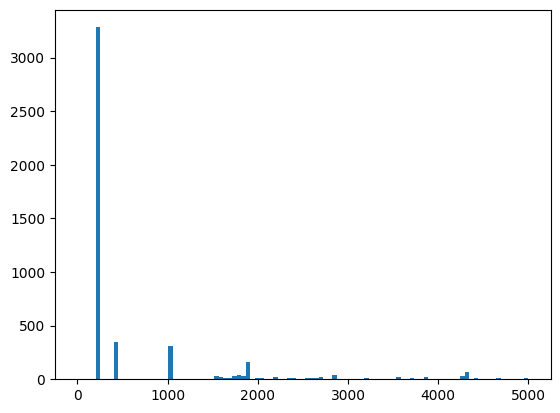

In [11]:
plt.hist(len_list, bins=np.linspace(0, 5000, 100));

# How many have lenght over 1000?
print(np.sum(np.array(len_list) > 1000))

# How many have length over 5000?
print(np.sum(np.array(len_list) > 5000))

In [12]:
transformer = Transformer(n_input=1)

x = jax.random.normal(jax.random.PRNGKey(0), (1, 200, 1))
init_rngs = {"params": jax.random.PRNGKey(0)}
out, params = transformer.init_with_output(init_rngs, x)

In [29]:
score_dict = {
            "d_model": 256,
            "d_mlp": 1024,
            "n_layers": 6,
            "n_heads": 4,
        }

vdm = VariationalDiffusionModel(d_feature=1, d_t_embedding=32, noise_scale=1e-4, noise_schedule="learned_linear")

init_rngs = {'params': jax.random.key(0), 'sample': jax.random.key(1)}
out, params = vdm.init_with_output(init_rngs, fluxes[:2, :, None], wavelengths[:2, :, None], masks[:2])

In [30]:
# Devices
num_local_devices = jax.local_device_count()
print(f"{num_local_devices} GPUs available")

4 GPUs available


In [31]:
# Define train state and replicate across devices

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=3e-4,
    warmup_steps=500,
    decay_steps=3000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-5)
state = TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)
pstate = replicate(state)

In [34]:
def loss_vdm(outputs, masks=None):
    loss_diff, loss_klz, loss_recon = outputs
    if masks is None:
        masks = np.ones(x.shape[:-1])

    loss_batch = (((loss_diff + loss_klz) * masks[:, :, None]).sum((-1, -2)) + (loss_recon * masks[:, :, None]).sum((-1, -2))) / masks.sum(-1)
    return loss_batch.mean()

@partial(jax.pmap, axis_name="batch",)
def train_step(state, fluxes, wavelenghts, masks, key_sample):
    
    def loss_fn(params):
        outputs = state.apply_fn(params, fluxes, wavelenghts, masks, rngs={"sample": key_sample})
        loss = loss_vdm(outputs, masks)
        return loss

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    return new_state, metrics

In [72]:
n_steps = 2000
n_batch = 32

key = jax.random.PRNGKey(0)

with trange(n_steps) as steps:
    for step in steps:
        key, *train_step_key = jax.random.split(key, num=jax.local_device_count() + 1)  # Split key across devices
        train_step_key = np.asarray(train_step_key)

        idx = jax.random.choice(key, fluxes.shape[0], shape=(n_batch,))

        fluxes_batch, wavelengths_batch, masks_batch = fluxes[idx], wavelengths[idx], masks[idx]

        # Split batches across devices
        fluxes_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), fluxes_batch)
        wavelengths_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), wavelengths_batch)
        masks_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), masks_batch)

        # Convert to np.ndarray
        fluxes_batch = np.array(fluxes_batch)
        wavelengths_batch = np.array(wavelengths_batch)
        masks_batch = np.array(masks_batch)
        
        pstate, metrics = train_step(pstate, fluxes_batch[..., None], wavelengths_batch[..., None], masks_batch, train_step_key)
        
        steps.set_postfix(loss=unreplicate(metrics["loss"]))

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:56<00:00, 35.15it/s, loss=23.949867]


In [77]:
from models.diffusion_utils import generate

# Generate samples
n_samples = 12
wavelengths_cond = wavelengths[:1, : np.sum(masks[0])]
wavelengths_cond = np.linspace(np.min(wavelengths_cond), np.max(wavelengths_cond), 214)[None, ...]
samples = generate(vdm, unreplicate(pstate).params, jax.random.PRNGKey(412141), (n_samples, len(wavelengths_cond[0])), wavelengths_cond[..., None], np.ones_like(wavelengths_cond), steps=200)

Text(0.5, 1.0, 'Generated spectra')

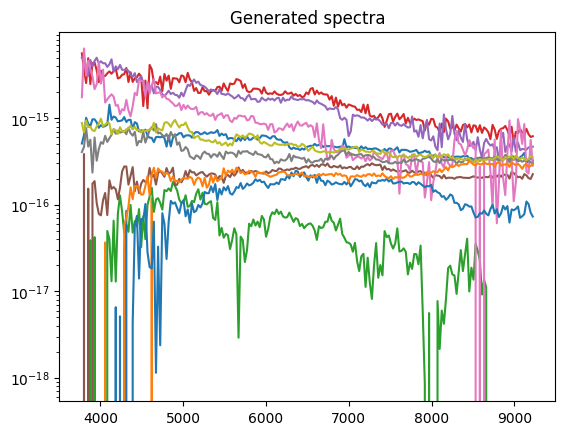

In [84]:
# Loop over all the samples
for i in range(n_samples):
    plt.plot(wavelengths_cond[0] * wavelengths_std + wavelengths_mean, samples.mean()[i, :, 0] * fluxes_std + fluxes_mean) # Generated sample

plt.yscale("log")
plt.title("Generated spectra")

Text(0.5, 1.0, 'Training spectra')

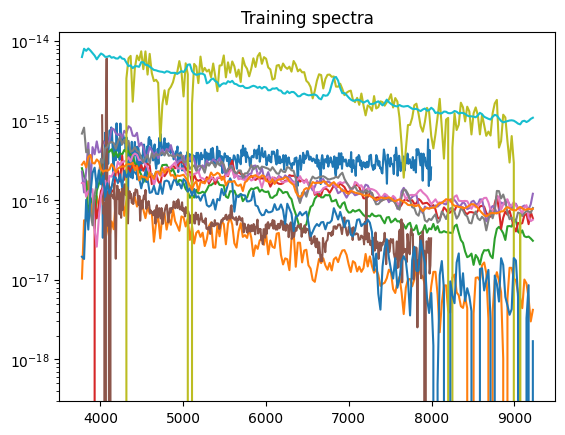

In [85]:
# Some training samples
for i in range(n_samples, n_samples + n_samples):
    wavelengths_unmaskes = wavelengths[i, masks[i]] * wavelengths_std + wavelengths_mean
    fluxes_unmasked = fluxes[i, masks[i]] * fluxes_std + fluxes_mean
    plt.plot(wavelengths_unmaskes, fluxes_unmasked) # Training sample

plt.yscale("log")
plt.title("Training spectra")